In [1]:
import bempp.api
import numpy as np
import scipy
import math
import time
import scipy.linalg 
import scipy.linalg.interpolative as sli
%matplotlib inline
from matplotlib import pyplot as plt

from bempp.api.assembly.blocked_operator import BlockedOperator
from numpy.linalg import slogdet
#bempp.api.enable_console_logging()

In [2]:
def get_box(nx, ny, mat, nboxes, n):
    """Return the content of a given box"""
    xrange = [nx * size, (1 + nx) * size] 
    yrange = [ny * size, (1 + ny) * size] 
    return mat[xrange[0]:xrange[1], yrange[0]:yrange[1]] 

In [3]:
def get_con_box(i,mat,nboxes,n):
    BB = mat[i * size : (i + 1) * size, :]
    B = np.delete(BB, np.s_[i*size : (i+1)*size], axis = 1)
    
    CC = np.transpose(mat[:, i * size : (i + 1) * size])
    C = np.delete(CC, np.s_[i*size : (i+1)*size], axis = 1)
    return np.hstack((B,C))

In [4]:
def L(i,k,mat,nboxes,n):
    idx1,proj1 = sli.interp_decomp(get_con_box(i,mat,nboxes,n), k, rand = False)
    B1 = sli.reconstruct_skel_matrix(get_con_box(i,mat,nboxes,n),k,idx1)
    B1_trans = np.transpose(B1)
    
    idx2,proj2 = sli.interp_decomp(B1_trans, k, rand = False)
    P2_trans = sli.reconstruct_interp_matrix(idx2,proj2)

    P2 = np.transpose(P2_trans)
    return P2,idx2

In [5]:
def index_set(k,mat,nboxes,n):
    l = []
    for i in range(nboxes):
        l.append(L(i,k,mat,nboxes,n)[1][0:k])
    return l

In [6]:
def S(k,mat,nboxes,n):
    ll = index_set(k,mat,nboxes,n)
    mat__ = np.zeros((k*nboxes,k*nboxes))
    for i in range(nboxes):
        for j in range(nboxes):
            if i != j:
                mat_ = get_box(i,j,mat,nboxes,n)[ll[i],:]
                mat__[i*k:(i+1)*k,j*k:(j+1)*k] = mat_[:,ll[j]]
    return mat__

In [7]:
def R(i,k,mat,nboxes,n):
    RR = np.transpose(L(i,k,mat,nboxes,n)[0])
    return RR

In [8]:
def new_S(k,mat,nboxes,n):
    mat_ = S(k,mat,nboxes,n)
    for i in range(nboxes):
        mat_[i*k:(i+1)*k,i*k:(i+1)*k] = np.linalg.inv(R(i,k,mat,nboxes,n) @ np.linalg.inv(get_box(i,i,mat,nboxes,n)) @ L(i,k,mat,nboxes,n)[0])
    return mat_

In [9]:
def logdet_(k,mat,nboxes,n):
    a1 = 0
    p1,l1,u1 = scipy.linalg.lu(new_S(k,mat,nboxes,n))
    for i in range(k*nboxes):
        a1 += math.log(abs(u1[i,i]))
        
    a2 = 0
    for i in range (nboxes):
        p2,l2,u2 = scipy.linalg.lu(get_box(i,i,mat,nboxes,n))
        for j in range(size):
            a2 +=math.log(abs(u2[j,j]))
            
    a3 = 0
    for i in range(nboxes):
        p3,l3,u3 = scipy.linalg.lu(-R(i,k,mat,nboxes,n)@np.linalg.inv(get_box(i,i,mat,nboxes,n)) @L(i,k,mat,nboxes,n)[0] )
        for j in range(k):
            a3 += math.log(abs(u3[j,j]))
    return a1 + a2 + a3

In [ ]:
size_elt = np.linspace(0.1,0.4,4)

N = 10
lbound = .05
ubound = 4

# We use an exponentially adapted trapezoid rule.
quad_points = np.linspace(np.exp(-ubound), np.exp(-lbound), N)
results = np.empty((5,N), dtype='float64')
matrices = []

center1 = (1.5, 0, 0) 
center2 = (-1.5, 0, 0)

for index1, h in enumerate(size_elt):

    sphere1 = bempp.api.shapes.sphere(h = h, origin = center1)
    sphere2 = bempp.api.shapes.sphere(h = h, origin = center2)
    
    rwg1 = bempp.api.function_space(sphere1, "RWG", 0)
    rwg2 = bempp.api.function_space(sphere2, "RWG", 0)

    snc1 = bempp.api.function_space(sphere1, "SNC", 0)
    snc2 = bempp.api.function_space(sphere2, "SNC", 0)
    
    for index2, point in enumerate(quad_points):
    
        wavenumber = -1j * np.log(point)

        op11 = bempp.api.operators.boundary.maxwell.electric_field(rwg1, rwg1, snc1, wavenumber)
        op22 = bempp.api.operators.boundary.maxwell.electric_field(rwg2, rwg2, snc2, wavenumber)
        op21 = bempp.api.operators.boundary.maxwell.electric_field(rwg1, rwg2, snc2, wavenumber)
        op12 = bempp.api.operators.boundary.maxwell.electric_field(rwg2, rwg1, snc1, wavenumber)
        
        mat11 = np.real(bempp.api.as_matrix(op11.weak_form()))
        mat12 = np.real(bempp.api.as_matrix(op12.weak_form()))
        mat21 = np.real(bempp.api.as_matrix(op21.weak_form()))
        mat22 = np.real(bempp.api.as_matrix(op22.weak_form()))
        ident_mat = np.identity(mat11.shape[0])
        
        A = ident_mat - np.linalg.inv(mat11)@mat12@np.linalg.inv(mat22)@mat21 

        sign, logdet = slogdet(A)
        results[index1,index2] = logdet
        matrices.append(A)

In [14]:
Casimir_energy = []
for i in range(4):
    Casimir_energy.append(np.trapz(-results[i,:] / quad_points, quad_points) / (2 * np.pi)) 

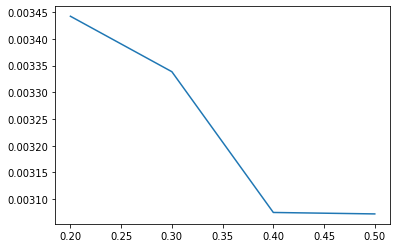

In [22]:
plt.plot(size_elt, Casimir_energy)

In [31]:
result_appro = np.empty((4,N),dtype='float64')

In [36]:
matrices[30].shape

(345, 345)

In [ ]:
for i in range(N):
    n = 
    nboxes = 
    size = n//nboxes
    result_appro[0,i] = logdet_(10,matrices[i],nboxes,n) #rank=10

In [ ]:
for i in range(N):
    n = 1272
    nboxes = 24
    size = n//nboxes
    result_appro[1,i] = logdet_(10,matrices[i+10],nboxes,n) #rank=10

In [33]:
for i in range(N):
    n = 717
    nboxes = 20
    size = n//nboxes
    result_appro[2,i] = logdet_(10,matrices[i+20],nboxes,n) #rank=10

In [35]:
for i in range(N):
    n = 348
    nboxes = 12
    size = n//nboxes
    result_appro[3,i] = logdet_(10,matrices[i+30],nboxes,n) #rank=10